In [1]:
import numpy as np

### We start by defining the class for the network and the functions we will need.

In [2]:
class Network:
    
    def __init__(self, V, c=np.array(None), s=None, t=None):
        '''
        V is the list of vertices names (string)
        s and t are respectively the source and the sink of the network:
        if not specified, we set them to be respectively the first and the last element in V
        c is the matrix of capacities, its size must be coherent with the length of V:
        if not specified, we set them to be None
        '''
        self.V = V
        if not s:
            s = V[0]
        if not t:
            t = V[-1]
        self.s = s
        self.t = t
        # We implement the adjacency set Adj as a nested dictionary:
        # the first key is the vertex of which we want to know the adjacent vertices,
        # the list of the keys of the nested dictionary is the adjacency list
        # the second key refers to the adjacent vertices, so it determines the edges and hence
        # it can be used to store the capacities (if positive) of such edges and the initial flow 0
        # We have that Adj[u][v] is the couple [c(u,v), f(u,v)] 
        # let us initialize the dictionary
        self.Adj = {}
        for u in V:
            self.Adj[u] = {}
        if c.any():
            for (i,u) in enumerate(V):
                for (j,v) in enumerate(V):
                    if c[i][j] > 0:
                        self.Adj[u][v] = [c[i][j], 0]
                    
    # To get the capacity of an edge
    def get_c(self,u,v):
        u = str(u); v = str(v)
        if not self.Adj[u].get(v):
            return 0
        return self.Adj[u][v][0]
    
    # To get the flow of an edge
    def get_f(self,u,v):
        u = str(u); v = str(v)
        if not self.Adj[u].get(v):
            return 0
        return self.Adj[u][v][1]
    
    # To add flow on an edge (u,v). We recall that increasing the flow
    # on the edge (u,v) is like decreasing it on the edge (v,u)
    def add_f(self,u,v,value):
        u = str(u); v = str(v)
        if self.get_f(v,u) >= value:
            self.Adj[v][u][1] -= value
        else:
            flow = self.get_f(u,v) + value - self.get_f(v,u)
            if (flow < 0) or (flow > self.get_c(u,v)):
                raise ValueError('The flow must be positive and it must not exceed the capacity of the edge!')
            self.Adj[u][v][1] = flow
            if self.get_c(v,u) > 0:
                self.Adj[v][u][1] = 0
    
    # To get the adjacency list of the vertex u with stored the capacities
    def get_Adj(self,u): 
        u = str(u)
        return self.Adj[u]
    
    # To get the residual capacity of the edge (u,v), i.e. how much flow on this edge can be added
    # We also have to keep in mind that there could be a flow on the edge (v,u) which contributes
    # to the total value of the flow which can be pushed on (u,v) 
    def get_cf(self,u,v):
        u = str(u); v = str(v)
        if self.get_f(u,v) > 0: # there is no flow on the edge (v,u)
            return self.get_c(u,v) - self.get_f(u,v)
        else:
            return self.get_c(u,v) + self.get_f(v,u)
        
    
    # To construct and return the adjacency set of the residual graph Gf
    # We recall that residual graphs do not have a flow
    def get_Gf(self):
        Gf = Network(self.V, s=self.s, t=self.t)
        for u in self.V:
            for v in self.get_Adj(u):
                if self.get_cf(u,v) > 0:
                    Gf.Adj[u][v] = self.get_cf(u,v)
        return Gf
    
    # In the Edmonds-Karp implementation, we find possible paths from the source s to the sink t
    # in the resitual graph Gf by using Breadth First Search: in this way we choose the augmeting path
    # as the shortest (in terms of number of edges traversed) path from s to t.
    # We want to keep track also of the path in order to find later the minimum cut: in order to do so,
    # we keep track with a dictionary the predecessor of each vertex visited
    def get_path(self):
        '''
        The output is a couple:
        1. the first entry is true if a path exists, false otherwise;
        2.1 if the first entry is false, the second one is the set of all the visited vertices (i.e. S of the minimum cut found);
        2.2 else, if the first entry is true, the second one is the ordered list of the vertices of the path.
        '''
        queue = [self.s] # we implement the queue as a list
        front = 0 # is the index of the front of the queue
        # in this way we do not need to remove the first element of the list for dequeuing
        # we are not worried about the space waste since we have a good upper bound: len(queue) <= V.
        visited = set()
        pred = {} # we initialize the dictionary of the predecessors
        while front < len(queue):
            u = queue[front]
            front += 1 # dequeue
            visited.add(u)
            if u == self.t: # we found a path from s to t
                # in order to find the path, we go backwards from the sink by means of pred
                path = [self.t]
                previous = pred[self.t]
                while previous != self.s:
                    path.append(previous)
                    previous = pred[previous]
                path.append(self.s)
                path.reverse()
                return (True,path)
            for v in self.get_Adj(u):
                if v not in visited: # to avoid loop, we put in the queue only not visited vertices
                    queue.append(v)
                    pred[v] = u
        return (False,visited)
   
    # To augment the flow on the path on Gf found with BFS by the minumum
    # among the residual capacities of the enges in the path
    def augment(self, path):
        '''
        path is represented as the ordered list of consecutive vertices visited by the path
        '''
        cfp = bool('Inf')
        for (i,u) in enumerate(path[:-1]):
            cfp = min(cfp, self.get_cf(u,path[i+1]))
        for (i,u) in enumerate(path[:-1]):
            self.add_f(u, path[i+1], cfp)
        
    # As long as a path is found in Gf by means of BFS, the flow is augmented.
    # Then, it returns S, one partition of the minimum cut (S,T)
    def FordFulkerson(self):
        BFS = self.get_Gf().get_path()
        while BFS[0]:
            self.augment(BFS[1])
            BFS = self.get_Gf().get_path()
        return BFS[1]

### Now we apply the Ford-Fulkerson algorithm to the graph of Zachary's karate club.

In [3]:
# We load the capacity matrix, where each value refers to the number of
# social interactions between to individuals of the club
c = np.loadtxt('ZachData.txt', delimiter=' ')

In [4]:
# We define the vertices names: Mi Hi will be number 1, whereas John A. number 34 
V = [str(u + 1) for u in range(34)]

In [5]:
# We create the network
KarateClub = Network(V, c)

Let us now use Ford-Fulkerson's algorithm to compute the cut $(S,T)$

In [6]:
S = KarateClub.FordFulkerson()
print(S)
T = set(V).difference(S)
print(T)

{'1', '12', '22', '20', '18', '6', '13', '4', '2', '17', '3', '14', '11', '8', '7', '5'}
{'26', '32', '29', '21', '28', '23', '34', '30', '16', '31', '25', '19', '27', '15', '10', '24', '9', '33'}


In [7]:
print("The maximum flow value is", sum([KarateClub.Adj['1'][v][1] for v in KarateClub.Adj['1']]))

The maximum flow value is 22


### Now we want to plot the network highlighting $S$ and $T$.

In order to do so, we will use networkx, where there is already a library containing the dataset (the only difference is in the labeling of the elements).

In [8]:
# nodes for the plot (different indeces)
Sprint=[]
for v in S:
    Sprint.append(int(v)-1)
Sprint

[0, 11, 21, 19, 17, 5, 12, 3, 1, 16, 2, 13, 10, 7, 6, 4]

In [9]:
# nodes for the plot (different indeces)
Tprint=[]
for v in T:
    Tprint.append(int(v)-1)
Tprint

[25, 31, 28, 20, 27, 22, 33, 29, 15, 30, 24, 18, 26, 14, 9, 23, 8, 32]

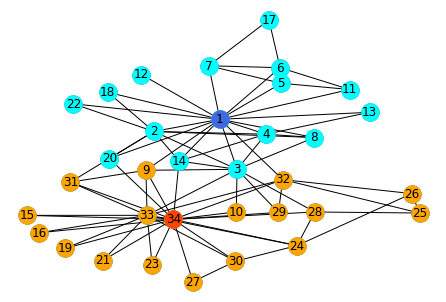

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.karate_club_graph()

labeldict = {}
for node in G.nodes:
    labeldict[node] = node + 1

graph = nx.kamada_kawai_layout(G)
nx.draw_kamada_kawai(G, with_labels=True, labels=labeldict)
#let's highlight Mr Hi (blue) and John A (red)
nx.draw_networkx_nodes(G, graph, nodelist=Sprint, node_color='aqua', alpha=1)
nx.draw_networkx_nodes(G, graph, nodelist=[0], node_color='royalblue', alpha=1)
nx.draw_networkx_nodes(G, graph, nodelist=Tprint, node_color='orange', alpha=1)
nx.draw_networkx_nodes(G, graph, nodelist=[33], node_color='orangered', alpha=1)
#plt.savefig('FF_plot')

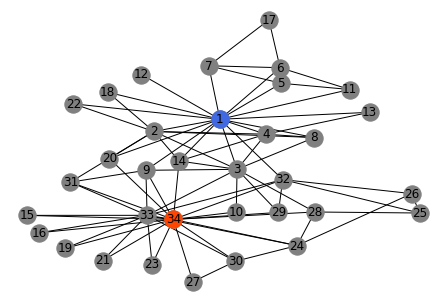

In [11]:
# We also plot the network
nx.draw_kamada_kawai(G, with_labels=True, labels=labeldict, node_color='grey')
nx.draw_networkx_nodes(G, graph, nodelist=[0], node_color='royalblue', alpha=1)
nx.draw_networkx_nodes(G, graph, nodelist=[33], node_color='orangered', alpha=1)
#plt.savefig('BeforeTheCut')